# Practical 3: Classification for probability to default (PD) modeling
<hr>
In this practice session, we consider the logistic regression model and study how it allows us to approach classification problems. 

The notebook comprises demo codes, which you can execute, and small programming tasks. For some tasks, you might know the answer already. In that case, just code your solution and move on. More likely, however, you might come across a task for which you do not know immediately what is the solution and/or how to code it. This is the normal. In programming, we spent a lot of time on web searching for demos, tutorials or searching question-forums like *stackoverflow* to find a solution to a programming problem. Hence, whenever you do not know *how* to perform a task, search for the answer on the internet. Web search is your friend!
Nowadays, as seen in our first practical, you can also get help from GenAI. Feel free to use GenAI for help when needed. However, when using GenAI, make sure to carefully read the explanations that come with generated code. This allows you to learn and progress. 

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Binary classification for PD modeling
The lecture introduced you to credit scoring, the problem of estimating the probability of credit applicants to repay debt.
<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/master/credit_scoring.png" alt="Credit Scoring" width="640" />
</p>

For this demo, we consider the *Home Equity (HMEQ)* data set from the textbook [Credit Risk Analytics](http://www.creditriskanalytics.net). It comprises information about a set of borrowers, which are categorized along demographic features and features concerning their business relationship with the lender. A binary target variable called *BAD* is provided and indicates whether a borrower has repaid their debt. 


**Info:** our GitHub repo provides a much more comprehensive analysis of this data set in our demo of a [fully-fledged machine learning pipeline](https://github.com/stefanlessmann/ESMT_IML/blob/main/notebooks/demo_ml_pipeline.ipynb). You are welcome to take a look if interested.
 

## Loading and preparing the data
Using the `Pandas` library, we can retrieve the data right from the web; specifically the GitHub repository of this course. 

In [2]:
data_location = 'https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/master/data/hmeq.csv'
df = pd.read_csv(data_location)  # standard pandas function to load tabular data in CSV format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Here is an overview of the data:
- BAD: the target variable, 1=default; 0=non-default
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

As you can see, the features aim to describe the financial situation of a borrower, which should probably tell us something about the risk of a borrower to default.

Run the below code to obtain a snapshot of the data.

In [3]:
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


The data requires at least a little bit of preparation to be ready for machine learning. First, we need to address the missing values. Second, two of the features, REASON and JOB, are non-numeric. Such categorical features cannot be used in a logistic regression model. We must convert them to numbers before using them. The following code addresses both problems in a quick (but also simplistic) way.

In [4]:
# Convert a category with k different values into k-1 binary variables. 
X = pd.get_dummies(df, dummy_na=True, drop_first=True)
X = X.dropna().reset_index(drop=True)  # drop all cases with one or more missing value
X["LOAN"] = X["LOAN"].astype(float)  # ensure that LOAN is stored as a float like all other numerical features


# Separate the data into a matrix of feature values and a target variable
y = X.pop('BAD')

## Excercise 1: Plotting data for classification
### a) Regression-like scatter plot
You will remember the many plots we came across when discussing linear regression. Let us try to create a similar plot for our classification problem. Specifically, create a **scatter plot** of the target variable `y` and the feature `LOAN`. Once a first version of the plot, adjust it such that cases (i.e., data points) from different classes (i.e., `BAD` = 0 and `BAD` = 1) are displayed in different colors.

>Extension (optional): we picked the feature `LOAN` for this plot. Using the function `.subplots()` from *Matplotlib*, you could create a whole grid of scatter plots, one for each feature. If trying to solve the extension, I suggest you restrict the analysis to numerical features using the *Pandas* function `.select_dtypes(include=['number'])`    

In [5]:
# Exercise 1a: scatter plot of target versus one feature


A striking result of the scatter plot stems form the binary target variable `y`. Along this axis, all data points are either zero or one. The key question is whether, based on the value of the feature, e.g., LOAN, we can infer whether the target is more likely to be zero or one. What is your opinion? 

### b) Scatter plot of two features 
Given that the *standard* scatter plot is somewhat dominated by the binary target, it makes sense to explore alternative visualizations. For instance, we could consider an augmented scatter plot of two features, for example, `LOAN` and `VALUE`, and color the data points according to the target variable `BAD`. This would allow us to see whether defaulters and non-defaulters cluster in different regions of the feature space spanned by `LOAN` and `VALUE`. Try to also create this visualization. In principle, you can select any two features that you like.

In [6]:
# Exercise 1b: scatter plot of two features
X1 = 'LOAN'  # select first feature of your choice
X2 = 'VALUE'  # select second feature of your choice


Assuming you solved exercise 1b, you will agree that the scatterplot of LOAN vs. VALUE does not seem very informative. More specifically, we cannot observe evidence that, using these two features, a predictive model would be able to distinguish good and bad payers well. Examining this question, which feature or which features are predictive of the target was also the subject of Exercise 1a. For the sake of completeness, we illustrate some more common visualizations we could consider to examine individual features predictiveness in a binary classification context. 

### Alternative visualizations for binary classification problems
#### Examining one numerical feature 


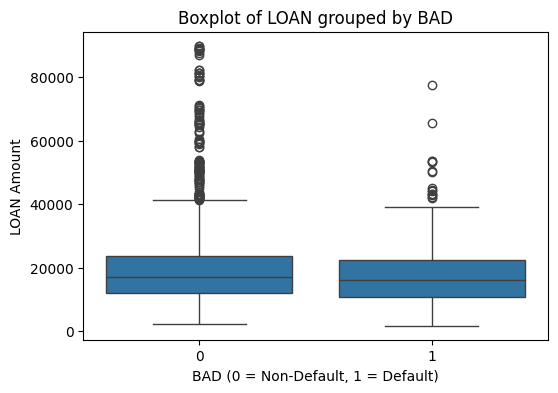

In [7]:
# Boxplot of one numerical feature grouped by the binary target
feature = 'LOAN'  # select feature of your choice
plt.figure(figsize=(6, 4))
sns.boxplot(x=y, y=X[feature])
plt.title(f'Boxplot of {feature} grouped by BAD')
plt.xlabel('BAD (0 = Non-Default, 1 = Default)')
plt.ylabel('LOAN Amount')
plt.show()

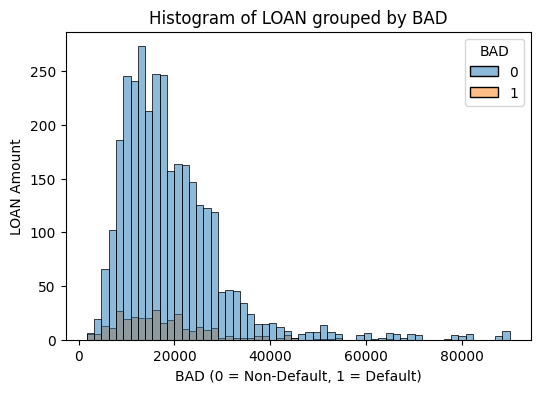

In [8]:
# Histogram of one numerical feature grouped by the binary target
feature = 'LOAN'  # select feature of your choice
plt.figure(figsize=(6, 4))
sns.histplot(x=X[feature], hue=y )
plt.title(f'Histogram of {feature} grouped by BAD')
plt.xlabel('BAD (0 = Non-Default, 1 = Default)')
plt.ylabel('LOAN Amount')
plt.show()

#### Examining one categorical feature

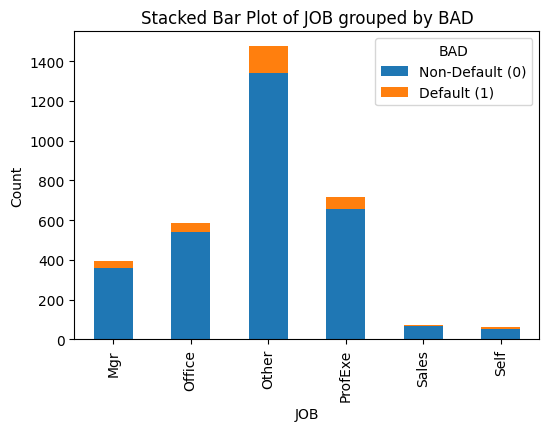

In [9]:
# Stacked bar plot of one categorical feature grouped by the binary target
categorical_feature = 'JOB'  # select categorical feature of your choice
contingency_table = pd.crosstab(df[categorical_feature], y)
contingency_table.plot(kind='bar', stacked=True,  figsize=(6, 4))
plt.title(f'Stacked Bar Plot of {categorical_feature} grouped by BAD')
plt.xlabel(categorical_feature)
plt.ylabel('Count')
plt.legend(title='BAD', labels=['Non-Default (0)', 'Default (1)'])
plt.show()

#### Examining one numerical together with a categorical feature and their impact on the target 

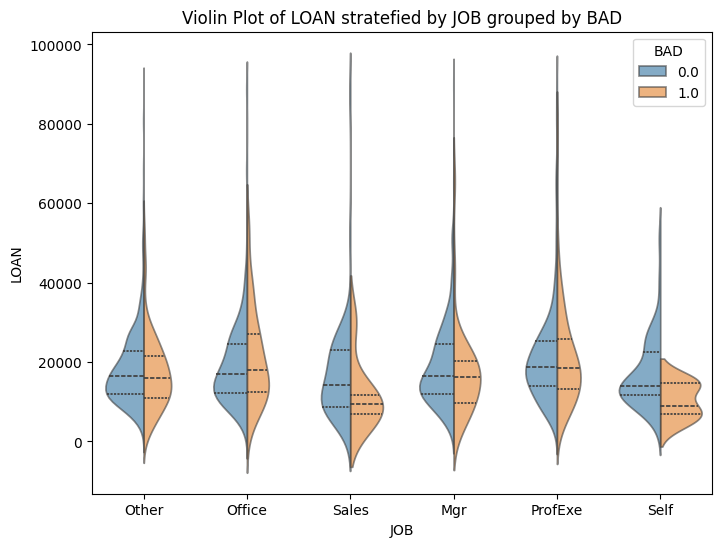

In [10]:
# Violin plot of one numerical feature grouped by the binary target
numerical_feature = 'LOAN'  # select numerical feature of your choice
categorical_featuer = 'REASON'  # select categorical feature of your choice
plt.figure(figsize=(8, 6))
sns.violinplot(x=df[categorical_feature], y=X[numerical_feature], hue=y, split=True,  inner="quart", alpha=0.6)
plt.title(f'Violin Plot of {numerical_feature} stratefied by {categorical_feature} grouped by BAD') 
plt.show()


# Classification models
The lecture introduced you to the logistic function and the logistic regression model. This part revisits both concepts. 

Recall the formula of the logistic function:

$$ \frac{1}{1+exp(-\eta)} $$
where
$$ \eta = b + w_1 x_1 + w_2 x_2 + ... + w_p x_p $$

Also recall how we can use the logistic function to *fit* observed data in a binary classification problem. 

<p align="left">
  <img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/master/logistic_function_playing.png" alt="Logistic function" width="640" />
</p>

The following code cell includes some prepared code that generates synthetic data of a binary classification problem with a single feature. The data is displayed in a scatter plot, just as in Exercise 1. The plot also includes the logistic function.



## Exercise 2: Fitting a logistic regression model by hand
The code allows you to set the two parameters of the logistic function, the intercept $b$ and the coefficient $w$ that scales the values of the feature $x$. This is shown in the above equation, whereby, in our simplified setting, we have only a single feature $x_1$. Your task is to find suitable values for these two parameters. Execute with different choice and inspect how well your logistic function models the classification problem.

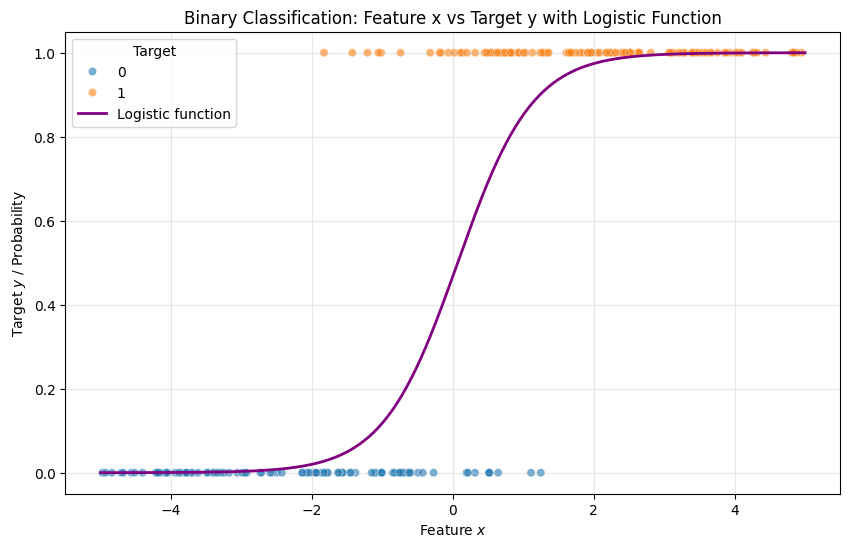

In [43]:
# Select parameters for the logistic function 1 + exp(constant + multiplier * x)
b = 0.13 # intercept analog
w = -1.88  # coefficient analog

# Creating synthetic data for a toy classification problem with one (informative feature) and a binary target
def toy_data(n_samples=200):
    '''
    Generate synthetic data for binary classification with one predictive numerical feature.
    Feature values of x are generated randomly from a uniform distribution in the range [-5, 5].
    The binary target y is generated based on x, such that higher values of x correspond to a higher probability of y=1.
    To achieve this, we sample y from a Bernoulli distribution where the success probability is determined by a logistic function of x.
    
    Parameters:
    ----------- 
    n_samples : int
        Number of samples to generate  (default = 100)
    
    Returns:
    --------
    x : array-like, shape (n_samples,)
        Generated feature values    
    y : array-like, shape (n_samples,)
        Generated binary target values (0 or 1)
    Example:
    --------    
    x, y = toy_data(n_samples=150)
    '''
    np.random.seed(123)  # ensure reproducibility by fixing the random seed
    x = np.random.uniform(-5, 5, n_samples)  # Generate feature x in the range [-5, 5]

    # Set the true parameters for the logistic function
    true_intercept = 0.13  # intercept
    true_coef = -1.88  # coefficient for x

    # Generate binary target y based on x (x is predictive of y)
    prob_y = 1 / (1 + np.exp(true_intercept + true_coef * x))  # Higher x values -> higher probability of y=1
    y = np.random.binomial(1, prob_y)
    
    return x, y

# Logistic function with user parameters
def logistic_function(x, multiplier=w, constant=b):
    """
    Computes logistic function: 1 / (1 + exp(constant+ multiplier * x)))
    
    Parameters:
    -----------
    x : array-like
        Input values
    multiplier : float, default=1
        Scaling factor for x
    constant : float, default=0
        Constant added to the product of x and multiplier (analog to the intercept in linear regression)
    
    Returns:
    --------    
    array-like
        Computed logistic function values
    Example:
    --------
    y = logistic_function(x, multiplier=2, constant=-1)
    """
    return 1 / (1 + np.exp(constant + multiplier * x ))

# Generate synthetic data
x, y_synthetic = toy_data(n_samples=200)

# Create visualization
plt.figure(figsize=(10, 6))

# Scatter plot of data
sns.scatterplot(x=x, y=y_synthetic, hue=y_synthetic, alpha=0.6)

# Plot logistic function
x_range = np.linspace(-5, 5, 300)
# User parameters: sign=1, constant=0, multiplier=1.5 (matching data generation)
y_logistic = logistic_function(x_range, constant=b, multiplier=w)
plt.plot(x_range, y_logistic, c='purple', linewidth=2, label='Logistic function')

plt.xlabel('Feature $x$')
plt.ylabel('Target $y$ / Probability')
plt.title('Binary Classification: Feature x vs Target y with Logistic Function')
plt.legend(title='Target')
plt.grid(True, alpha=0.3)
plt.show()

## Logistic regression
Exercises 2 sketches the main principles of fitting a classification model, more specifically a logistic regression. In practice, model fitting involves minimizing the (binary) cross-entropy loss functions over the observed *labeled* data using gradient-based algorithms. We discuss this in more detail in the lecture. Here, we illustrate how to fit a logistic regression model in Python using the `sklearn` library.

>Note that this library is designed for supervised machine learning. If your goal was to use logisitc regression for explanatory modeling, for example, to understand the effect of features on the target variable, compute elasticities, and so on, then `sklearn` would be a bad choice. It does not support explanatory modeling; certainly not as well as alternative libraries would. You could consider the  `statsmodels` for developing explanatory logistic regression models. Explanatory modeling in general and using logistic regression in particular is discussed in your *Econometrics *class. We focus on predictive modeling.

### Model training
Just as in linear regression, logistic regression involves model training on labelled data. The below code uses the `sklearn` library to train a logistic regression ,model on our HMEQ credit risk dataset. To ensure the code is self-contained, we repeat the data loading and preparation steps from above.


In [12]:
# Repeat data loading and preparation (see above parts for details)
from sklearn.preprocessing import StandardScaler
data_location = 'https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/master/data/hmeq.csv'
df = pd.read_csv(data_location) 
X = df.dropna().reset_index(drop=True)  
y = X.pop('BAD')
numerical_features = X.select_dtypes(include=['number']).columns
X = pd.get_dummies(X, dummy_na=True, drop_first=True)
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X, y)  # we define a random_state to ensure that we get the same results when re-running this cell multiple times
print(model)

LogisticRegression()


As said, `sklearn` is designed for predictive modeling. Therefore, our logit model provides a function `.predict()` to obtain predictions for some input data. For simplicity, we compute prediction for the training data. You already learnt that this is inappropriate. We do it here to keep things simple. 

In [14]:
yhat = model.predict(X)  # simple way to compute predictions using logistic regression and any other machine learning model in sklearn 

Likely, you are also interested to assess the model. There is an easy way to do this:

In [15]:
perf = model.score(X, y)  # Call a general purpose evaluation function and obtain a (quality ) score of the model
print('Logit model achieves a score of {:.3f} %'.format(perf*100))

Logit model achieves a score of 92.658 %


### Exercise 3: Diagnosing predictions
A score of above 90 percent sounds very good. Actually, it is not, and your task is to find out why. Let's break it down into pieces.

#### a) What score?
Check the [sklearn documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) to understand what kind of score the function `score()` has provided. What is it that we see?



**Your answer:** 

#### b) Is it good or is it bad?
Interpreting our score will be easier if we compare it to a baseline. But what baseline? We face a classification problem. There are two classes, good payers and bad payers, and we aim to tell these apart. A very basic strategy could be to classify every observation into the majority class. Write code to implement this naive strategy and compute the percentage of correct classifications. You manually determine which class, 0 or 1, is the majority. However, a better approach would be to first determine the majority class by writing some code. 

In [16]:
# Code to calculate as the percentage of correct classifications of a naive classifier that classifies every case into the majority class


If you succeeded with the previous task, you will have found that a super-basic - stupid - classifier also performs very well, which puts our previous result for the logistic regression into perspective. 

#### c) What about probabilities?
Exactly, what about probabilities? The lecture introduced classification as a machine learning setup aimed at predicting class membership probabilities. So logistic regression should answer questions such as "what is the estimated probability of the first credit applicant in our data set to repay?" To do this, we must use a different `slklearn` function, namely `.predict_proba()`. Use this function to compute the class membership probabilities for the first five credit applicants in our data set. 

In [17]:
# Compute probabilistic predictions using .predict_proba()


### Visualizing the logistic regression
Now that we can compute probabilisitc predictions, we can conclude this session with a nice visualization of the logistic regression model fitted above. More specifically, we need to fit one more model, this time using only two features. This allows us to nicely visualize the decision boundary of the logistic regression in a two-dimensional feature space (i.e., a scatterplot).
#### Exercise 4: One more logistic regression
Please estimate a second logistic regression model using only two features. In principal, you could use any combination of features. Exercise 1 has shed light on which features might be more informative. Consider drawing on this knowledge to select meaningful features.  

In [18]:
# Write code to estimate a logistic regression classifier using only the two above features


#### The visual logistic regression
As you will have guessed, the point of the above exercise was only to obtain a logistic regression model that we can plot; hence the need to select two features. 
The visualization is somewhat complex. Thus, all code is readily available for you. Below we provide a function `plot_logit_decision_surface()`. 
**Do not be put off by the length of the code.** You are not supposed to look through the function at this point. Of course you can, but do not allow it to confuse you. It is a function to create a plot. That is all you need to know for now. Please execute the cell to make sure you can use the function in the next exercise. 

In [19]:
def plot_logit_decision_surface(model, data, x1="LOAN", x2="VALUE"):
    '''
        Visualization of logistic regression in 2D
        
        Creates a plot depicting the distribution of the input
        data along two dimensions and the probability predictions
        of a logistic regression model. 

        Parameters
        ----------
        model :   An instance of the sklearn class LogisticRegression,  which        
                  has been trained on the input data.

        data  :   Pandas data frame providing the feature values.

        x1, x2:   The function plots the results of logistic regression in
                  two dimensions. The parameters x1 and x2 give the names
                  of the features used for plotting. These features will be
                  extracted from the data frame.


        Returns
        ----------
        The function does not return a result. It's purpose is to visualize 
        logistic regression model. The corresponding plot is the only output.
    '''

    #if len(model.coef_.ravel())!=2:
    #    raise Exception('Please estimate a logit model using only two features!')
    # Define some variables to govern the plot
    bounds = data.describe().loc[["min", "max"]][[x1, x2]].to_numpy()  # value ranges of the two features
    eps = 5  # tolerance parameter 

    # Create hypothetical data points spanning the entire range of feature values.
    # We need these to get from our logistic regression model a probability prediction
    # for every possible data point
    xx, yy = np.mgrid[(bounds[0,0]-eps):(bounds[1,0]+eps), (bounds[0,1]-eps):(bounds[1,1]+eps)]
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Perhaps the logistic regression model was fitted using the full data frame. 
    # To also work in that case, we extract the estimated regression coefficients 
    # corresponding to the two features we consider for plotting
    feature_to_index = {name: idx for idx, name in enumerate(model.feature_names_in_)}  # create a dic as intermediate step
    indices = [feature_to_index[f] for f in [x1, x2]]  # Find the indices of our two features of interest using the dic
    w = model.coef_.ravel()[indices]  # estimated regression coefficients
    b = model.intercept_  # estimated intercept of the logistic regression model

    # Compute probability predictions over the entire space of possible feature values
    # In the interest of robustness, we manually compute the logistic regression predictions
    # using the regression coefficients extracted above
    probs = 1/(1+np.exp(-(np.dot(grid, w.reshape(2,-1))+b))).reshape(xx.shape)

    # We are finally ready to create our visualization
    f, ax = plt.subplots(figsize=(8, 6))  # new figure
    # Contour plot of the probability predictions across the entire feature range
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)  
    ax_c = f.colorbar(contour)
    ax_c.set_label("$\hat{p}(y=1|X)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    # Scatter plot of the actual data
    ax.scatter(data[x1], data[x2], c=y, s=50, cmap="RdBu", vmin=0, vmax=1,
               edgecolor="white", linewidth=1);
    plt.xlabel(x1)
    plt.ylabel(x2)
    plt.show()

<>:58: SyntaxWarning: invalid escape sequence '\h'
<>:58: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_32409/1484332005.py:58: SyntaxWarning: invalid escape sequence '\h'
  ax_c.set_label("$\hat{p}(y=1|X)$")


#### Exercise 5: Surface plot
We are almost ready. To finish, write a piece of code to call our `plot_logit_decision_surface()`. Familiarize yourself with the function's interface first. Then, invoking it shohuld not be too difficult. 
I guess your next task is obvious. Write code to call the function providing the necessary parameters so that it can do its job. If used correctly, the function will create a plot like this one:

<p align="left">
  <img src="https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/logit_contour.png" alt="Logit decision surface" width="640" />
</p>


Let's if it works for you...

In [20]:
# Code to call the function plot_logit_decision_surface()


Finally, and hoping you got a nice contour plot of your logistic regression model, it is time to pause and think about the plot. It tells you a lot about how logistic regression works and the output you obtain. This is something we need to discuss in class. 

# Well done! This was another comprehensive set of exercises.